In [7]:
# Hemophilia A
# 0.24 percent of population of hemophilia A patients are unknown
import numpy as np

known_population_probabilities_ha = np.array([0.01, 0.12, 0.07, 0.37, 0.19])
known_population_probabilities_hb = np.array([0.02, 0.10, 0.06, 0.39, 0.19])
unknown_ha = 1 - np.sum(known_population_probabilities_ha)
unknown_hb = 1 - np.sum(known_population_probabilities_hb)

get_logger().info("Calculating mean for age groups")
target_ha = [
    df_known_a["0-4"].mean(),
    df_known_a["5-13"].mean(),
    df_known_a["14-18"].mean(),
    df_known_a["19-44"].mean(),
    df_known_a["45+"].mean(),
]

target_hb = [
    df_known_b["0-4"].mean(),
    df_known_b["5-13"].mean(),
    df_known_b["14-18"].mean(),
    df_known_b["19-44"].mean(),
    df_known_b["45+"].mean(),
]

# Calculate the required adjustment
get_logger().info(
    "Calculating required adjustment to minimize distribution difference from mean"
)
d_ha = target_ha - known_population_probabilities_ha
d_hb = target_hb - known_population_probabilities_hb


get_logger().info(
    "Minimizing the sum of squared differences between the unknown portion and the required adjustment"
)
from scipy.optimize import minimize

# Objective function: sum of squire differences
# x0: Initial guess: equal distribution
# bounds:  All values >= 0
res_ha = minimize(
    lambda x: np.sum((x - d_ha) ** 2),
    x0=np.ones(5) * unknown_ha / 5,
    method="SLSQP",
    bounds=([(0, None)] * 5),
    constraints={"type": "eq", "fun": lambda x: np.sum(x) - unknown_ha},
)

res_hb = minimize(
    lambda x: np.sum((x - d_hb) ** 2),
    x0=np.ones(5) * unknown_hb / 5,
    method="SLSQP",
    bounds=([(0, None)] * 5),
    constraints={"type": "eq", "fun": lambda x: np.sum(x) - unknown_hb},
)

x_opt_ha = res_ha.x  # [0.068214, 0.102500, 0.067358, 0.001928, 0.0]
x_opt_hb = res_hb.x  # [0.070185, 0.124907, 0.064907, ~0.0 , 0.0]

# Final distribution
POPULATION_PROBABILITIES_HA = known_population_probabilities_ha + x_opt_ha
POPULATION_PROBABILITIES_HB = known_population_probabilities_hb + x_opt_hb

assert np.sum(POPULATION_PROBABILITIES_HA) == 1
assert np.sum(POPULATION_PROBABILITIES_HB) == 1

INFO: Calculating mean for age groups
INFO: Calculating required adjustment to minimize distribution difference from mean
INFO: Minimizing the sum of squared differences between the unknown portion and the required adjustment


INFO: Population size: 5914


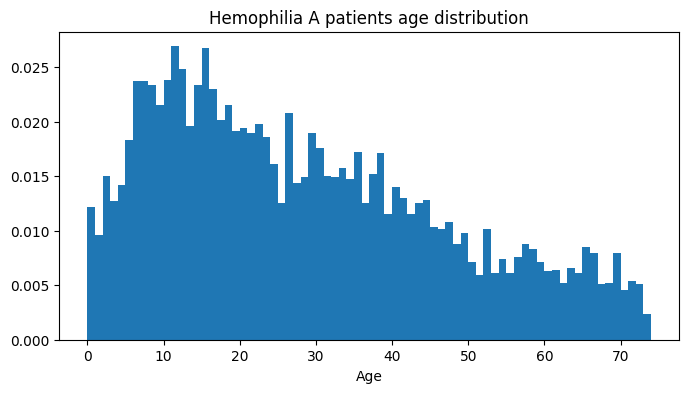

In [ ]:
# WHF 2020 Report
HEMOPHILIA_A_PROBS_2020 = [0.04, 0.13, 0.08, 0.55, 0.21]

# According to WHF 2023 report
TOTAL_HEMOPHILIA_A_PATIENTS = 5914
TOTAL_HEMOPHILIA_B_PATIENTS = 1282
MAX_AGE = 74

# Defining population age ranges
AGE_BINS = [
    range(0, 5),
    range(5, 14),
    range(14, 19),
    range(19, 45),
    range(45, MAX_AGE),
]


# calculating patients age distribution in population,
# assigning equal probabilities to all ages within each bin
def generate_equal_bin_probabilities(
    age_bins: list[range], bin_probabilities: list[float]
) -> np.ndarray:
    """
    Generate piecewise-constant probabilities for each age in bins.

    **Note**: Causes abrupt jumps at bin boundaries
    """
    full_age_probabilities = np.array([])
    # each probability is weighted to simulated the age of simulated patients
    for age_range, bin_prob in zip(age_bins, bin_probabilities):
        # Get all ages in current bin
        ages_in_bin = np.arange(
            age_range.start, age_range.stop, age_range.step, dtype=int
        )
        # Distribute bin probability equally across ages
        per_age_probability = np.array([bin_prob / ages_in_bin.size] * ages_in_bin.size)
        # Concatenate to full probability array
        full_age_probabilities = np.concatenate(
            (full_age_probabilities, per_age_probability)
        )
    return full_age_probabilities


def generate_kde_smoothed_probabilities(
    age_bins: list[range], bin_probabilities: list[float], smoothing_factor: float = 0.2
):
    """Generate smoothed age probabilities using Kernel Density Estimation."""
    from scipy.stats import gaussian_kde

    # Generate representative samples
    all_samples = []
    for age_range, bin_prob in zip(age_bins, bin_probabilities):
        n_samples = int(bin_prob * 10_000)
        # Create samples proportional to bin probability
        samples_in_bin = np.random.uniform(
            age_range.start, age_range.stop, size=n_samples
        )
        all_samples.append(samples_in_bin)
    combined_samples = np.concatenate(all_samples)
    # Combine and fit KDE
    kde = gaussian_kde(combined_samples, bw_method=smoothing_factor)
    # Evaluate at each integer age
    ages = np.arange(0, MAX_AGE)
    smoothed_probs: np.ndarray = kde(ages)
    # Normalize probabilities to sum 1
    smoothed_probs /= smoothed_probs.sum()
    return smoothed_probs


possible_distribution = []
for alpha in np.linspace(0, 1, 100):
    P = (1 - alpha) * np.array(
        HEMOPHILIA_A_PROBS_2020
    ) + alpha * POPULATION_PROBABILITIES_HA
    possible_distribution.append(P.tolist())

# Generate probability distributions
# equal_bin_probs_ha = generate_equal_bin_probabilities(AGE_BINS, POPULATION_PROBABILITIES_HA)  # type: ignore
kde_smoothed_probs_ha = generate_kde_smoothed_probabilities(AGE_BINS, POPULATION_PROBABILITIES_HA, smoothing_factor=0.3)  # type: ignore
# Generate population using smoothed distribution
from model.population import Population

population_model = Population(
    total_patients=TOTAL_HEMOPHILIA_A_PATIENTS,
    max_age=MAX_AGE,
    age_probabilities=kde_smoothed_probs_ha,
)
patient_ages = population_model.generate(is_shuffled=False)
get_logger().info(f"Population size: {patient_ages.size}")

# Analyze age distribution
age_series = pd.Series(patient_ages)
age_bin_edges = [0, 5, 14, 19, 45, 74]
age_bin_labels = ["0-5", "5-14", "14-19", "19-45", "45-74"]

# Categorize ages into bins
age_categories = pd.cut(
    age_series, bins=age_bin_edges, labels=age_bin_labels, right=False
)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# TODO:
# Considering 2020 Age distribution report
# Animating histogram changes over time

# Plot 1: Histogram (Age Distribution)
plt.figure(1, figsize=(8, 4))
plt.title("Hemophilia A patients age distribution")
plt.hist(age_series, bins=np.arange(0, MAX_AGE + 1).tolist(), density=True)
plt.xlabel("Age")

# Plot 2: Linear Plot (Smoothed Distribution)
if False:
    plt.figure(2, figsize=(8, 4))
    age_counts = age_series.value_counts().sort_index()
    plt.plot(age_counts, label="Smoothed Age Distribution")
    plt.title("Hemophilia A patients age distribution")
    plt.xlabel("Age")
    plt.ylabel("Number of Patients")

# Plot 3: Bar Plot (Age Group Distribution)
if False:
    plt.figure(3, figsize=(8, 4))
    age_group_counts = age_categories.value_counts(sort=False).loc[age_bin_labels]
    plt.bar(age_bin_labels, age_group_counts.tolist())
    plt.xlabel("Age groups")
    plt.ylabel("Number of patients")

# Display all figures
plt.show()

In [9]:
from enum import Enum
from model.patient import Patient
import statsmodels.api as sm

class State(Enum):
    NO_BLEEDING = "alive_wo_arthropathy"
    CHRONIC_ARTHROPATHY = "alive_w_arthropathy"
    MINOR_BLEEDING = "extra_articular_bleeding"
    MAJOR_BLEEDING = "articular_bleeding"
    COMPLICATION = "surgery_or_injury"
    DEATH = "dies_from_bleeding"
    INHIBITER = "developing_inhibiter"


treatmentOptions = ["prophylaxis", "on-demand"]

# Memory-less Markov Processing avoided
# Instead Dynamic Switching Dynamic Regression or Hidden Markov Model considered

# Discrete Time Markov chain
# A system which is in a certain state at each steps,
# with the state changing randomly between steps.

# Defining hemophilia A states
# Each states shall be a particular condition that
# a patient can occupy during his life

states = [state.value for state in State]
df_1400 = pd.DataFrame(columns=states)
df_1400.insert(loc=0, column="states", value=states)

# Transition probabilities between states (Transition matrix)
transitionProbabilities: dict = {}

df_1400.head(df_1400.__len__())

,states,alive_wo_arthropathy,alive_w_arthropathy,extra_articular_bleeding,articular_bleeding,surgery_or_injury,dies_from_bleeding,developing_inhibiter
0,alive_wo_arthropathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,alive_w_arthropathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,extra_articular_bleeding,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,articular_bleeding,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,surgery_or_injury,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,dies_from_bleeding,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,developing_inhibiter,NaN,NaN,NaN,NaN,NaN,NaN,NaN
